### 2) Training Decoders in Practice

Now that we have discussed the conceptual foundations, strategies and techniques involved, lets walk through a detailed example of how to train a decoder.

#### 2a) Requirements

The following packages are required, and can be installed via PIP:

<ol>
  <li> Python 3 (with numpy and scipy)</li>
  <li> tensorflow </li>
  <li> keras </li> 
  <li> gym </li> 
</ol> 

In addition, a modified version of the Keras-RL package is required, which should be installed from <a href="https://github.com/R-Sweke/keras-rl">this fork</a>

In [1]:
import numpy as np
import keras
import tensorflow
import gym

from Function_Library import *
from Environments import *

import rl as rl
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy, GreedyQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import FileLogger

import json
import copy
import sys
import os
import shutil
import datetime

Using TensorFlow backend.


In [2]:
fixed_configs = {"d": 5,
                "use_Y": False,
                "train_freq": 1,
                "batch_size": 32,
                "print_freq": 250,
                "rolling_average_length": 500,
                "stopping_patience": 500,
                "error_model": "X",
                "c_layers": [[64,3,2],[32,2,1],[32,2,1]],
                "ff_layers": [[512,0.2]],
                "max_timesteps": 1000000,
                "volume_depth": 5,
                "testing_length": 101,
                "buffer_size": 50000,
                "dueling": True,
                "masked_greedy": False,
                "static_decoder": True}

variable_configs = {"p_phys": 0.001,
                    "p_meas": 0.001,
                    "success_threshold": 10000,
                    "learning_starts": 1000,
                    "learning_rate": 0.00001,
                    "exploration_fraction": 100000,
                    "max_eps": 1.0,
                    "target_network_update_freq": 5000,
                    "gamma": 0.99,
                    "final_eps": 0.02}

logging_directory = os.path.join(os.getcwd(),"logging_directory/")
static_decoder_path = os.path.join(os.getcwd(),"referee_decoders/nn_d5_X_p5")


all_configs = {}

for key in fixed_configs.keys():
    all_configs[key] = fixed_configs[key]

for key in variable_configs.keys():
    all_configs[key] = variable_configs[key]

static_decoder = load_model(static_decoder_path)                                                 
logging_path = os.path.join(logging_directory,"training_history.json")
logging_callback = FileLogger(filepath = logging_path,interval = all_configs["print_freq"])

In [3]:
env = Surface_Code_Environment_Multi_Decoding_Cycles(d=all_configs["d"], 
    p_phys=all_configs["p_phys"], 
    p_meas=all_configs["p_meas"],  
    error_model=all_configs["error_model"], 
    use_Y=all_configs["use_Y"], 
    volume_depth=all_configs["volume_depth"],
    static_decoder=static_decoder)

In [4]:
model = build_convolutional_nn(all_configs["c_layers"], 
                               all_configs["ff_layers"], 
                               env.observation_space.shape, 
                               env.num_actions)

memory = SequentialMemory(limit=all_configs["buffer_size"], window_length=1)

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(masked_greedy=all_configs["masked_greedy"]), 
    attr='eps', value_max=all_configs["max_eps"], 
    value_min=all_configs["final_eps"], 
    value_test=0.0, 
    nb_steps=all_configs["exploration_fraction"])

test_policy = GreedyQPolicy(masked_greedy=True)

In [5]:
dqn = DQNAgent(model=model, 
               nb_actions=env.num_actions, 
               memory=memory, 
               nb_steps_warmup=all_configs["learning_starts"], 
               target_model_update=all_configs["target_network_update_freq"], 
               policy=policy,
               test_policy = test_policy,
               gamma = all_configs["gamma"],
               enable_dueling_network=all_configs["dueling"])  


dqn.compile(Adam(lr=all_configs["learning_rate"]))

In [6]:
now = datetime.datetime.now()
started_file = os.path.join(logging_directory,"started_at.p")
pickle.dump(now, open(started_file, "wb" ) )

history = dqn.fit(env, 
  nb_steps=all_configs["max_timesteps"], 
  action_repetition=1, 
  callbacks=[logging_callback], 
  verbose=2,
  visualize=False, 
  nb_max_start_steps=0, 
  start_step_policy=None, 
  log_interval=all_configs["print_freq"],
  nb_max_episode_steps=None, 
  episode_averaging_length=all_configs["rolling_average_length"], 
  success_threshold=all_configs["success_threshold"],
  stopping_patience=all_configs["stopping_patience"],
  min_nb_steps=all_configs["exploration_fraction"],
  single_cycle=False)

Training for 1000000 steps ...
-----------------
                
Episode: 250
Step: 2232/1000000
This Episode Steps: 4
This Episode Reward: 0.0
This Episode Duration: 0.122s
Rolling Lifetime length: 38.000
Best Lifetime Rolling Avg: 52.857142857142854
Best Episode: 6
Time Since Best: 243
Has Succeeded: False
Stopped Improving: False
Metrics: loss: 0.024631, mean_q: 0.104172, mean_eps: 0.978151
Total Training Time: 42.201s

-----------------
                
Episode: 500
Step: 4482/1000000
This Episode Steps: 7
This Episode Reward: 1.0
This Episode Duration: 0.201s
Rolling Lifetime length: 39.290
Best Lifetime Rolling Avg: 52.857142857142854
Best Episode: 6
Time Since Best: 493
Has Succeeded: False
Stopped Improving: False
Metrics: loss: 0.023562, mean_q: 0.120933, mean_eps: 0.956116
Total Training Time: 106.792s

-----------------
                
Episode: 750
Step: 6816/1000000
This Episode Steps: 17
This Episode Reward: 0.0
This Episode Duration: 0.458s
Rolling Lifetime length: 40.4

-----------------
                
Episode: 5500
Step: 67704/1000000
This Episode Steps: 9
This Episode Reward: 2.0
This Episode Duration: 0.262s
Rolling Lifetime length: 106.920
Best Lifetime Rolling Avg: 107.24
Best Episode: 5483
Time Since Best: 16
Has Succeeded: False
Stopped Improving: False
Metrics: loss: 0.224453, mean_q: 2.257581, mean_eps: 0.336550
Total Training Time: 1885.324s

-----------------
                
Episode: 5750
Step: 75097/1000000
This Episode Steps: 115
This Episode Reward: 50.0
This Episode Duration: 3.092s
Rolling Lifetime length: 143.220
Best Lifetime Rolling Avg: 143.22
Best Episode: 5749
Time Since Best: 0
Has Succeeded: False
Stopped Improving: False
Metrics: loss: 0.279388, mean_q: 3.023634, mean_eps: 0.264618
Total Training Time: 2086.488s

-----------------
                
Episode: 6000
Step: 89611/1000000
This Episode Steps: 37
This Episode Reward: 24.0
This Episode Duration: 1.061s
Rolling Lifetime length: 279.420
Best Lifetime Rolling Avg: 279.42

In [15]:
weights_file = os.path.join(logging_directory, "dqn_weights.h5f")
dqn.save_weights(weights_file, overwrite=True)

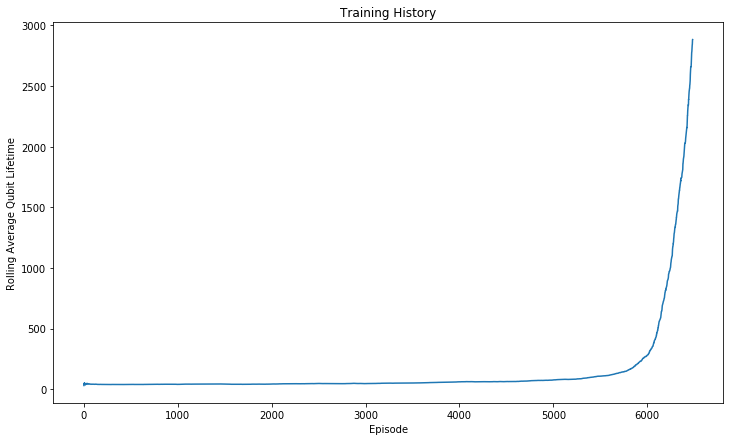

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

training_history = history.history["episode_lifetimes_rolling_avg"]

plt.figure(figsize=(12,7))
plt.plot(training_history)
plt.xlabel('Episode')
plt.ylabel('Rolling Average Qubit Lifetime')
_ = plt.title("Training History")